# UCEC Reccurance Notebook - Model Training

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Impliment these models
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt

import joblib
import config

In [2]:
# Load training data using paths from config
X_train = joblib.load(config.X_TRAIN_PATH)
y_train = joblib.load(config.Y_TRAIN_PATH)

In [3]:
def run_random_forest_classifier():
    # Code for training Random Forest
    print("Running random forest classifier")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=1e-5)), 
        # ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif)),
        ('clf', RandomForestClassifier(random_state=config.SEED, class_weight='balanced'))
    ])

    # Define hyperparameter grid
    param_grid = {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10, 15],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2, 4],
        'select__k': [20, 50, 100, 500],
        'clf__max_features': ['sqrt', 'log2', 0.1]  # Reduce feature space per tree
    }
    return pipeline, param_grid


def run_svc_with_LASSO():
    # Define LASSO feature selector
    lasso_selector = SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000),
        threshold='mean'
    )

    # Define SVC classifier
    svc_clf = SVC(probability=True, class_weight='balanced', random_state=config.SEED)

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', lasso_selector),
        ('classifier', svc_clf)
    ])

    # Hyperparameter grid
    param_grid = {
        'feature_selection__estimator__C': [0.01, 0.1, 1],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }

    return pipeline, param_grid


def run_svc():

    # Define SVC classifier
    svc_clf = SVC(probability=True, class_weight='balanced', random_state=config.SEED)

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('classifier', svc_clf)
    ])

    # Hyperparameter grid
    param_grid = {
        'select__k': [20, 50, 100, 500],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }

    return pipeline, param_grid

def run_xgboost(y_train):
    # Define LASSO feature selector
    lasso_selector = SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000),
        threshold='mean'  # or use "1e-5" to keep more
    )

    # Define XGBoost classifier
    xgb_clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=config.SEED,
        scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1))  # ratio of negatives over positives
    )

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', lasso_selector),
        ('classifier', xgb_clf)
    ])

    

    # Hyperparameter grid (you can expand this)
    param_grid = {
        'feature_selection__estimator__C': [0.01, 0.1, 1],
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
    }
    return pipeline, param_grid


def run_logistic_regression():
    # Define the pipeline with Logistic Regression
    print("Running Logistic Regression")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(class_weight='balanced', random_state=config.SEED))
    ])

    # define hyperparameter grid for logistic regression
    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'select__k': [50, 100, 500, 1000]
    }
    return pipeline, param_grid

def run_logistic_regression_with_LASSO():
    print("Running Logistic Regression with LASSO")

    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            random_state=config.SEED,
            max_iter=10000,
            verbose=1
        ))
    ])

    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10]  # Smaller C = more sparsity
    }

    return pipeline, param_grid

# CHANGE WHICH MODEL USED HERE
pipeline, param_grid = run_logistic_regression()
# pipeline, param_grid = run_svc()
# pipeline, param_grid = run_logistic_regression_with_LASSO()

# Set up cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1,
    verbose=3
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# [6416 12260 12263 12264 12392 12400 12416 12426 12431 12526 12527 12892 13602 14340 16428 18227 20043] are constant.

Running Logistic Regression
Fitting 3 folds for each of 20 candidates, totalling 60 fits


Looking at the hyperparameter tuning

In [4]:
print("Overall best params:", grid_search.best_params_, "\n")

# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


Overall best params: {'clf__C': 0.01, 'select__k': 50} 

Parameters: {'clf__C': 0.01, 'select__k': 50}
Mean AUC-ROC: 0.6487
Standard Deviation: 0.0341
------------------------------
Parameters: {'clf__C': 0.01, 'select__k': 100}
Mean AUC-ROC: 0.6450
Standard Deviation: 0.0238
------------------------------
Parameters: {'clf__C': 0.01, 'select__k': 500}
Mean AUC-ROC: 0.6404
Standard Deviation: 0.0238
------------------------------
Parameters: {'clf__C': 0.01, 'select__k': 1000}
Mean AUC-ROC: 0.6328
Standard Deviation: 0.0123
------------------------------
Parameters: {'clf__C': 0.1, 'select__k': 50}
Mean AUC-ROC: 0.6265
Standard Deviation: 0.0432
------------------------------
Parameters: {'clf__C': 0.1, 'select__k': 100}
Mean AUC-ROC: 0.6190
Standard Deviation: 0.0149
------------------------------
Parameters: {'clf__C': 0.1, 'select__k': 500}
Mean AUC-ROC: 0.6048
Standard Deviation: 0.0204
------------------------------
Parameters: {'clf__C': 0.1, 'select__k': 1000}
Mean AUC-ROC: 0.61

In [5]:
# Save the best estimator from GridSearchCV
joblib.dump(best_model, config.LR_MODEL_PATH) # change the path depending on the model
print("Model saved to:", config.LR_MODEL_PATH)


Model saved to: models/logistic_regression.pkl


Analyzing the prediction of the training data

True Positives (TP): 52
False Positives (FP): 80
True Negatives (TN): 249
False Negatives (FN): 15
AUC-ROC Score: 0.7665


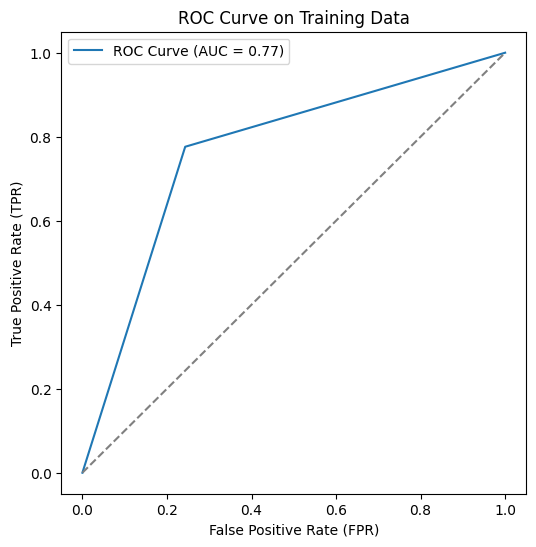

In [6]:
y_train_pred = best_model.predict(X_train)

cm_test = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_train, y_train_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

Analyzing the performace on the training data

True Positives (TP): 12
False Positives (FP): 26
True Negatives (TN): 56
False Negatives (FN): 5
AUC-ROC Score: 0.6944


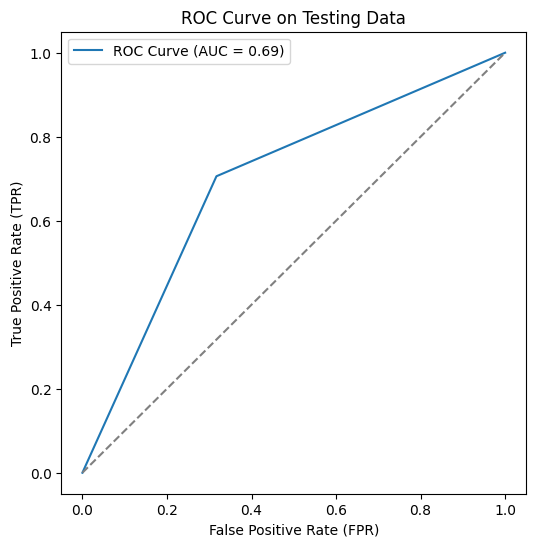

In [7]:
X_test = joblib.load(config.X_TEST_PATH)
y_test = joblib.load(config.Y_TEST_PATH)

y_test_pred = best_model.predict(X_test)

cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()

In [ ]:
# Top Feature Analysis for Random Forest Classifier

feature_names = joblib.load(config.FEATURE_NAMES)

# Step 1: get mask from VarianceThreshold
vt = best_model.named_steps["variance_threshold"]
vt_mask = vt.get_support()
vt_features = feature_names[vt_mask]  # surviving features after variance threshold

# Step 2: get mask from SelectKBest
skb = best_model.named_steps["select"]
skb_mask = skb.get_support()
skb_features = vt_features[skb_mask]  # surviving features after SelectKBest

# Step 3: get feature importances from RandomForest
clf = best_model.named_steps["clf"]
importances = clf.feature_importances_

# Step 4: zip names + importances
feature_importances = sorted(
    zip(skb_features, importances),
    key=lambda x: x[1],
    reverse=True
)

# Display top features
print("Top 15 features:")
for feat, score in feature_importances[:15]:
    print(f"{feat}: {score:.4f}")


AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [ ]:
def analyze_top_features(model, feature_names, top_n=15):
    """
    Analyze top features for a fitted sklearn pipeline with feature selection + classifier.
    Works for RandomForest (feature_importances_) and LogisticRegression (coef_).
    
    Parameters
    ----------
    model : fitted sklearn Pipeline
        The best estimator (e.g., from GridSearchCV.best_estimator_).
    feature_names : array-like
        Original feature names before feature selection.
    top_n : int
        Number of top positive/negative features to display.
    """

    # Step 1: VarianceThreshold
    vt = model.named_steps.get("variance_threshold")
    if vt is not None:
        vt_mask = vt.get_support()
        vt_features = feature_names[vt_mask]
    else:
        vt_features = feature_names

    # Step 2: SelectKBest
    skb = model.named_steps.get("select")
    if skb is not None:
        skb_mask = skb.get_support()
        skb_features = vt_features[skb_mask]
    else:
        skb_features = vt_features

    # Step 3: Classifier
    clf = model.named_steps["clf"]

    # --- Case 1: Tree-based models ---
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        df = pd.DataFrame({
            "feature": skb_features,
            "importance": importances
        }).sort_values("importance", ascending=False)

        print(f"\nTop {top_n} features (importance only):")
        print(df.head(top_n))

        return df

    # --- Case 2: Linear models (e.g. Logistic Regression) ---
    elif hasattr(clf, "coef_"):
        if clf.coef_.shape[0] == 1:  
            coefs = clf.coef_[0]  # binary classification
        else:
            coefs = np.mean(clf.coef_, axis=0)  # average for multiclass

        df = pd.DataFrame({
            "feature": skb_features,
            "coefficient": coefs
        }).sort_values("coefficient", ascending=False)

        print(f"\nTop {top_n} POSITIVE features (increase recurrence likelihood):")
        print(df.head(top_n))

        print(f"\nTop {top_n} NEGATIVE features (protective against recurrence):")
        print(df.tail(top_n))

        return df

    else:
        raise ValueError("Classifier does not expose feature_importances_ or coef_")

analyze_top_features(best_model, feature_names)


Top 15 POSITIVE features (increase recurrence likelihood):
     feature  coefficient
17     GNAT2     0.213596
2   C11orf86     0.156361
34     PRDX6     0.118206
43      TCP1     0.109274
41       SST     0.095474
7       CCT3     0.093780
45      VARS     0.083782
28     NAA50     0.075053
47      YARS     0.068353
15    FAM49B     0.054233
25     MTCH1     0.053433
9    CREB3L1     0.045845
27       MYC     0.045714
20     HSPD1     0.043603
42     STIP1     0.042040

Top 15 NEGATIVE features (protective against recurrence):
     feature  coefficient
22  LBX2-AS1    -0.036844
38   RASGRF1    -0.043620
36    RABL2B    -0.043939
3   C11orf93    -0.044305
14     EPB49    -0.046974
46      XPO5    -0.052066
4   C9orf103    -0.059989
32     PCSK4    -0.063581
24      MSX2    -0.069260
49     ZNF69    -0.077040
0    ADAMTS8    -0.089603
21      LBX2    -0.093532
31     NPAS3    -0.095318
40      SMG6    -0.133117
5     CARD10    -0.136883


,feature,coefficient
17,GNAT2,0.213596
2,C11orf86,0.156361
34,PRDX6,0.118206
43,TCP1,0.109274
41,SST,0.095474
7,CCT3,0.093780
45,VARS,0.083782
28,NAA50,0.075053
47,YARS,0.068353
15,FAM49B,0.054233
